# Importación y análisis

In [67]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import matplotlib.dates as mdates
from sklearn.preprocessing import RobustScaler
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score, confusion_matrix 


In [2]:
datos = pd.read_csv('caudal_extra.csv', parse_dates=['fecha'])


In [ ]:
datos.head(5)

In [ ]:
datos.shape

In [ ]:
print(datos.info)

In [ ]:
datos.describe()

In [ ]:
#identifico columnas con valores nulos
datos.isnull().sum(axis = 0)

In [ ]:
datos_na = datos[datos.isna().any(axis=1)]

In [ ]:
datos_na.sort_values(by=['fecha'])


Elimino las filas con na, ya que el objetivo es predecir caudal en base a precipitaciones y temperatura,
y el dataset tiene 27767 missing values de precipitación y 151563 de temperatura.
Luego para graficar las 3 variables tampoco me sirve tener filas con uno o dos valores ya que es inconsistente
Finalmente manejo un solo dataset con la misma cantidad de registros para cada una de las 3 variables.


In [3]:
datos.dropna(inplace = True)

In [ ]:
## Transformación datos columna fecha para dejar en formato Año/mes/día, ya que el dato de la hora no es relevante
## y simplifica el input para la función de plots.
#datos['fecha'] = datos['fecha'].dt.strftime('%Y/%m/%d')



# Plots Distribuciones

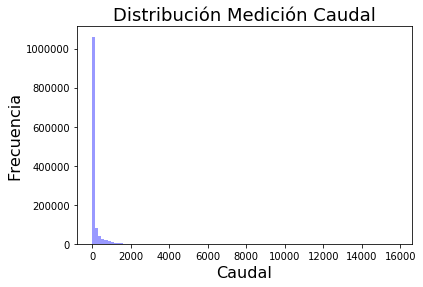

In [4]:
sns.distplot(datos['caudal'], kde=False, color='blue', bins=100)
plt.title('Distribución Medición Caudal', fontsize=18)
plt.xlabel('Caudal', fontsize=16)
plt.ylabel('Frecuencia', fontsize=16)
plt.show()

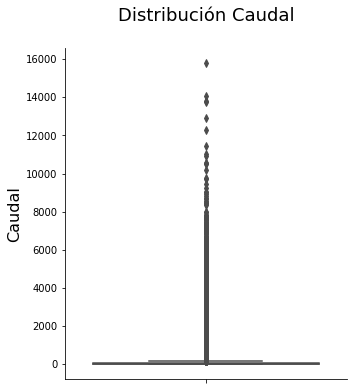

In [5]:
sns.catplot(y="caudal", kind = "box", data=datos, color = 'blue')
plt.title('Distribución Caudal\n', fontsize=18)
plt.ylabel('Caudal', fontsize=16)
plt.show()

Con respecto a la distribución de Caudal se observa que se encuentra concentrada en valores cercanos al cero, y lo que se escapa de la distribución(asimétrica) deben ser los eventos extremos que claramente se salen de lo que es la norma en la medición de esta variable.

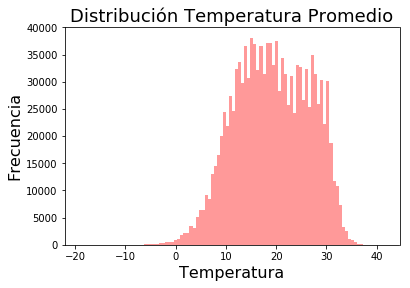

In [6]:
sns.distplot(datos['temp_max_promedio'], kde=False, color='red', bins=100)
plt.title('Distribución Temperatura Promedio', fontsize=18)
plt.xlabel('Temperatura', fontsize=16)
plt.ylabel('Frecuencia', fontsize=16)
plt.show()

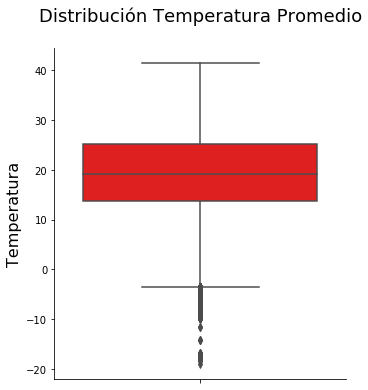

In [7]:
sns.catplot(y="temp_max_promedio", kind = "box", data=datos, color = 'red')
plt.title('Distribución Temperatura Promedio\n', fontsize=18)
plt.ylabel('Temperatura', fontsize=16)
plt.show()

Con respecto a la distibución de Temperatudas promedio, el 50% de los casos se encuentran entre 14 y 25 grados aproximadamente. Las colas nos muestran los valores máximos cercano a 40 grados y mínimos en grados bajo cero, también con muchos valores de ouliers inferiores a -5.

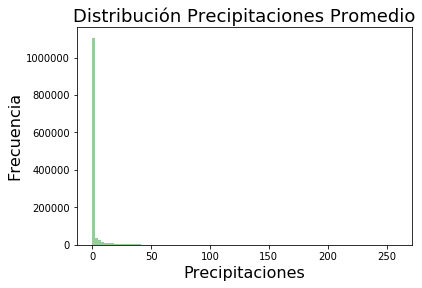

In [8]:
sns.distplot(datos['precip_promedio'], kde=False, color='green', bins=100)
plt.title('Distribución Precipitaciones Promedio', fontsize=18)
plt.xlabel('Precipitaciones', fontsize=16)
plt.ylabel('Frecuencia', fontsize=16)
plt.show()

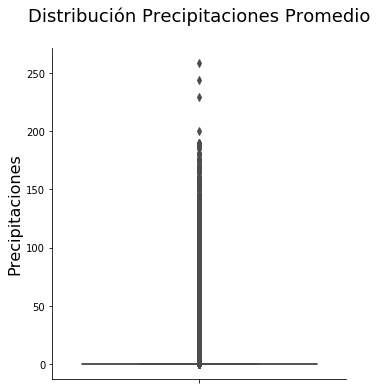

In [9]:
sns.catplot(y="precip_promedio", kind = "box", data=datos, color = 'red')
plt.title('Distribución Precipitaciones Promedio\n', fontsize=18)
plt.ylabel('Precipitaciones', fontsize=16)
plt.show()

En el caso de las precipitaciones vemos algo muy similar a lo que sucede con Caudal, los valores están concentrados  cercanos al cero y aquellos que se escapan de la norma representan muy probablemente a los eventos en que ocurren eventos extremos

# 3. Plots de precipitación, temperatura y caudal

Función plot de datos para una sola columna(variable):

In [10]:
def time_plot_una_estacion(codigo_estacion, columna, fecha_min,
fecha_max):
    df_plot = datos[(datos['codigo_estacion'] == codigo_estacion) & (datos['fecha']>=fecha_min)& (datos['fecha']<=fecha_max)]
    sns.lineplot(x = 'fecha', y = columna ,data = df_plot, color='blue')
    plt.title("Código [{}]".format(codigo_estacion), fontsize=18)
    plt.xlabel('Fecha', fontsize=16)
    plt.ylabel(columna, fontsize=16)
    plt.xticks()
    plt.tight_layout()
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    plt.setp(plt.gca().get_xticklabels(), rotation=45, ha="right")
    
    

/anaconda3/lib/python3.7/site-packages/seaborn/relational.py:792: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  x, y = np.asarray(x), np.asarray(y)
/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


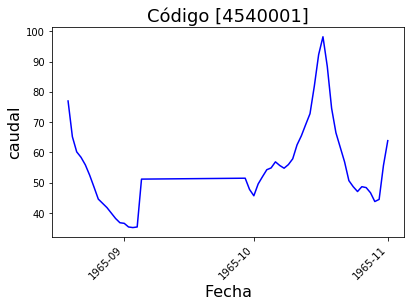

In [11]:
time_plot_una_estacion(4540001,'caudal', '1965/08/01', '1965/11/01')

Función plot de datos tres columnas(variables):
Utilizo RobustScaler para la normalización ya que considera el efecto de los outliers, los cuales para este caso son relevantes. Por ejemplo el StandarScaler, no garantiza que el escalamiento deje la información bien balanceada en presencia de outliers.

In [12]:
datos[['caudal', 'precip_promedio', 'temp_max_promedio']] = RobustScaler().fit_transform(datos[['caudal', 'precip_promedio', 'temp_max_promedio']])
datos

,Unnamed: 0,codigo_estacion,institucion,fuente,nombre,altura,latitud,longitud,codigo_cuenca,nombre_sub_cuenca,cantidad_observaciones,fecha,caudal,gauge_id,gauge_name,precip_promedio,temp_max_promedio
32,32,4540001,DGA,dga_web,Rio Grande En Paloma 1,310,-30.683300,-71.050003,45,Rio Grande Bajo (Entre E Paloma Y Rio Hurtado),11575,1965-08-19 00:00:00+00:00,0.929574,4540001,Rio Grande En Paloma 1,0.000000,0.208696
33,33,4540001,DGA,dga_web,Rio Grande En Paloma 1,310,-30.683300,-71.050003,45,Rio Grande Bajo (Entre E Paloma Y Rio Hurtado),11575,1965-09-05 00:00:00+00:00,0.574691,4540001,Rio Grande En Paloma 1,0.000000,0.121739
34,34,4540001,DGA,dga_web,Rio Grande En Paloma 1,310,-30.683300,-71.050003,45,Rio Grande Bajo (Entre E Paloma Y Rio Hurtado),11575,1965-10-06 00:00:00+00:00,0.653095,4540001,Rio Grande En Paloma 1,0.000000,0.252174
35,35,4540001,DGA,dga_web,Rio Grande En Paloma 1,310,-30.683300,-71.050003,45,Rio Grande Bajo (Entre E Paloma Y Rio Hurtado),11575,1965-10-15 00:00:00+00:00,0.996974,4540001,Rio Grande En Paloma 1,0.000000,0.121739
36,36,4540001,DGA,dga_web,Rio Grande En Paloma 1,310,-30.683300,-71.050003,45,Rio Grande Bajo (Entre E Paloma Y Rio Hurtado),11575,1965-12-21 00:00:00+00:00,0.563686,4540001,Rio Grande En Paloma 1,0.000000,0.817391
37,37,4540001,DGA,dga_web,Rio Grande En Paloma 1,310,-30.683300,-71.050003,45,Rio Grande Bajo (Entre E Paloma Y Rio Hurtado),11575,1966-02-04 00:00:00+00:00,0.032737,4540001,Rio Grande En Paloma 1,0.000000,0.513043
38,38,4540001,DGA,dga_web,Rio Grande En Paloma 1,310,-30.683300,-71.050003,45,Rio Grande Bajo (Entre E Paloma Y Rio Hurtado),11575,1966-03-23 00:00:00+00:00,-0.082393,4540001,Rio Grande En Paloma 1,0.000000,0.730435
39,39,4540001,DGA,dga_web,Rio Grande En Paloma 1,310,-30.683300,-71.050003,45,Rio Grande Bajo (Entre E Paloma Y Rio Hurtado),11575,1966-04-11 00:00:00+00:00,-0.091747,4540001,Rio Grande En Paloma 1,0.000000,0.165217
40,40,4540001,DGA,dga_web,Rio Grande En Paloma 1,310,-30.683300,-71.050003,45,Rio Grande Bajo (Entre E Paloma Y Rio Hurtado),11575,1966-07-29 00:00:00+00:00,0.120770,4540001,Rio Grande En Paloma 1,0.000000,-0.226087
41,41,4540001,DGA,dga_web,Rio Grande En Paloma 1,310,-30.683300,-71.050003,45,Rio Grande Bajo (Entre E Paloma Y Rio Hurtado),11575,1966-08-20 00:00:00+00:00,0.067125,4540001,Rio Grande En Paloma 1,0.000000,0.121739


In [13]:
def time_plot_estaciones_varias_columnas(codigo_estacion,columnas, fecha_min, fecha_max):
    df_plot = datos[(datos['codigo_estacion'] == codigo_estacion) & (datos['fecha']>=fecha_min)& (datos['fecha']<=fecha_max)]
    colores = ['blue', 'orange','green']
    for indice, columna in enumerate(columnas):
        sns.lineplot(x = 'fecha', y = columna ,data = df_plot, color=colores[indice] , label = columna)
    #sns.lineplot(x = 'fecha', y = columnas ,data = df_plot, color='blue')
    plt.title("Código [{}]".format(codigo_estacion), fontsize=18)
    plt.xlabel('Fecha', fontsize=16)
    #plt.ylabel('')
    plt.xticks()
    plt.tight_layout()
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    plt.setp(plt.gca().get_xticklabels(), rotation=45, ha="right")
    

/anaconda3/lib/python3.7/site-packages/seaborn/relational.py:792: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  x, y = np.asarray(x), np.asarray(y)


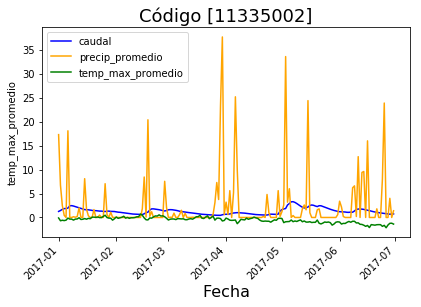

In [14]:
time_plot_estaciones_varias_columnas(11335002,['caudal','precip_promedio','temp_max_promedio'], '2017/01/01', '2017/07/31')


# Nuevas variables

In [15]:
def season_of_date(date):
    year = str(date.year)
    seasons = {'autum': pd.date_range(start='21/03/'+year, end='20/06/'+year),
               'winter': pd.date_range(start='21/06/'+year, end='22/09/'+year),
               'spring': pd.date_range(start='23/09/'+year, end='20/12/'+year)}
    if date in seasons['autum']:
        return 'otono'
    if date in seasons['winter']:
        return 'invierno'
    if date in seasons['spring']:
        return 'primavera'
    else:
        return 'verano'


    

In [ ]:
# Apply season_of_date to 'fecha' column and create new 'season' column with results
datos['season'] = datos.fecha.map(season_of_date)

In [ ]:
datos

In [16]:
#datos.to_csv('Datos_estaciones.csv')
datos = pd.read_csv('Datos_estaciones.csv', parse_dates=['fecha'])

In [17]:
datos.drop(columns = ['Unnamed: 0','Unnamed: 0.1'], inplace = True)
datos

,codigo_estacion,institucion,fuente,nombre,altura,latitud,longitud,codigo_cuenca,nombre_sub_cuenca,cantidad_observaciones,fecha,caudal,gauge_id,gauge_name,precip_promedio,temp_max_promedio,season
0,4540001,DGA,dga_web,Rio Grande En Paloma 1,310,-30.683300,-71.050003,45,Rio Grande Bajo (Entre E Paloma Y Rio Hurtado),11575,1965-08-19 00:00:00+00:00,0.929574,4540001,Rio Grande En Paloma 1,0.000000,0.208696,invierno
1,4540001,DGA,dga_web,Rio Grande En Paloma 1,310,-30.683300,-71.050003,45,Rio Grande Bajo (Entre E Paloma Y Rio Hurtado),11575,1965-09-05 00:00:00+00:00,0.574691,4540001,Rio Grande En Paloma 1,0.000000,0.121739,invierno
2,4540001,DGA,dga_web,Rio Grande En Paloma 1,310,-30.683300,-71.050003,45,Rio Grande Bajo (Entre E Paloma Y Rio Hurtado),11575,1965-10-06 00:00:00+00:00,0.653095,4540001,Rio Grande En Paloma 1,0.000000,0.252174,primavera
3,4540001,DGA,dga_web,Rio Grande En Paloma 1,310,-30.683300,-71.050003,45,Rio Grande Bajo (Entre E Paloma Y Rio Hurtado),11575,1965-10-15 00:00:00+00:00,0.996974,4540001,Rio Grande En Paloma 1,0.000000,0.121739,primavera
4,4540001,DGA,dga_web,Rio Grande En Paloma 1,310,-30.683300,-71.050003,45,Rio Grande Bajo (Entre E Paloma Y Rio Hurtado),11575,1965-12-21 00:00:00+00:00,0.563686,4540001,Rio Grande En Paloma 1,0.000000,0.817391,verano
5,4540001,DGA,dga_web,Rio Grande En Paloma 1,310,-30.683300,-71.050003,45,Rio Grande Bajo (Entre E Paloma Y Rio Hurtado),11575,1966-02-04 00:00:00+00:00,0.032737,4540001,Rio Grande En Paloma 1,0.000000,0.513043,verano
6,4540001,DGA,dga_web,Rio Grande En Paloma 1,310,-30.683300,-71.050003,45,Rio Grande Bajo (Entre E Paloma Y Rio Hurtado),11575,1966-03-23 00:00:00+00:00,-0.082393,4540001,Rio Grande En Paloma 1,0.000000,0.730435,otono
7,4540001,DGA,dga_web,Rio Grande En Paloma 1,310,-30.683300,-71.050003,45,Rio Grande Bajo (Entre E Paloma Y Rio Hurtado),11575,1966-04-11 00:00:00+00:00,-0.091747,4540001,Rio Grande En Paloma 1,0.000000,0.165217,otono
8,4540001,DGA,dga_web,Rio Grande En Paloma 1,310,-30.683300,-71.050003,45,Rio Grande Bajo (Entre E Paloma Y Rio Hurtado),11575,1966-07-29 00:00:00+00:00,0.120770,4540001,Rio Grande En Paloma 1,0.000000,-0.226087,invierno
9,4540001,DGA,dga_web,Rio Grande En Paloma 1,310,-30.683300,-71.050003,45,Rio Grande Bajo (Entre E Paloma Y Rio Hurtado),11575,1966-08-20 00:00:00+00:00,0.067125,4540001,Rio Grande En Paloma 1,0.000000,0.121739,invierno


In [19]:
#Agrego columnas con los percentiles
datos_agrupado = datos.groupby(['codigo_estacion','season'])
datos['caudal_percentil'] = datos_agrupado['caudal'].transform(lambda x: x.quantile(.95))
datos['precip_percentil'] = datos_agrupado['precip_promedio'].transform(lambda x: x.quantile(.95))
datos['temp_percentil'] = datos_agrupado['temp_max_promedio'].transform(lambda x: x.quantile(.95))
datos

,codigo_estacion,institucion,fuente,nombre,altura,latitud,longitud,codigo_cuenca,nombre_sub_cuenca,cantidad_observaciones,fecha,caudal,gauge_id,gauge_name,precip_promedio,temp_max_promedio,season,caudal_percentil,precip_percentil,temp_percentil
0,4540001,DGA,dga_web,Rio Grande En Paloma 1,310,-30.683300,-71.050003,45,Rio Grande Bajo (Entre E Paloma Y Rio Hurtado),11575,1965-08-19 00:00:00+00:00,0.929574,4540001,Rio Grande En Paloma 1,0.000000,0.208696,invierno,0.229986,7.406667,0.663768
1,4540001,DGA,dga_web,Rio Grande En Paloma 1,310,-30.683300,-71.050003,45,Rio Grande Bajo (Entre E Paloma Y Rio Hurtado),11575,1965-09-05 00:00:00+00:00,0.574691,4540001,Rio Grande En Paloma 1,0.000000,0.121739,invierno,0.229986,7.406667,0.663768
2,4540001,DGA,dga_web,Rio Grande En Paloma 1,310,-30.683300,-71.050003,45,Rio Grande Bajo (Entre E Paloma Y Rio Hurtado),11575,1965-10-06 00:00:00+00:00,0.653095,4540001,Rio Grande En Paloma 1,0.000000,0.252174,primavera,0.892847,0.000000,0.988000
3,4540001,DGA,dga_web,Rio Grande En Paloma 1,310,-30.683300,-71.050003,45,Rio Grande Bajo (Entre E Paloma Y Rio Hurtado),11575,1965-10-15 00:00:00+00:00,0.996974,4540001,Rio Grande En Paloma 1,0.000000,0.121739,primavera,0.892847,0.000000,0.988000
4,4540001,DGA,dga_web,Rio Grande En Paloma 1,310,-30.683300,-71.050003,45,Rio Grande Bajo (Entre E Paloma Y Rio Hurtado),11575,1965-12-21 00:00:00+00:00,0.563686,4540001,Rio Grande En Paloma 1,0.000000,0.817391,verano,0.064374,0.000000,1.032348
5,4540001,DGA,dga_web,Rio Grande En Paloma 1,310,-30.683300,-71.050003,45,Rio Grande Bajo (Entre E Paloma Y Rio Hurtado),11575,1966-02-04 00:00:00+00:00,0.032737,4540001,Rio Grande En Paloma 1,0.000000,0.513043,verano,0.064374,0.000000,1.032348
6,4540001,DGA,dga_web,Rio Grande En Paloma 1,310,-30.683300,-71.050003,45,Rio Grande Bajo (Entre E Paloma Y Rio Hurtado),11575,1966-03-23 00:00:00+00:00,-0.082393,4540001,Rio Grande En Paloma 1,0.000000,0.730435,otono,0.038102,1.102348,0.852174
7,4540001,DGA,dga_web,Rio Grande En Paloma 1,310,-30.683300,-71.050003,45,Rio Grande Bajo (Entre E Paloma Y Rio Hurtado),11575,1966-04-11 00:00:00+00:00,-0.091747,4540001,Rio Grande En Paloma 1,0.000000,0.165217,otono,0.038102,1.102348,0.852174
8,4540001,DGA,dga_web,Rio Grande En Paloma 1,310,-30.683300,-71.050003,45,Rio Grande Bajo (Entre E Paloma Y Rio Hurtado),11575,1966-07-29 00:00:00+00:00,0.120770,4540001,Rio Grande En Paloma 1,0.000000,-0.226087,invierno,0.229986,7.406667,0.663768
9,4540001,DGA,dga_web,Rio Grande En Paloma 1,310,-30.683300,-71.050003,45,Rio Grande Bajo (Entre E Paloma Y Rio Hurtado),11575,1966-08-20 00:00:00+00:00,0.067125,4540001,Rio Grande En Paloma 1,0.000000,0.121739,invierno,0.229986,7.406667,0.663768


In [20]:
#Conviero valores booleanos en 1 y 0
datos['caudal_extremo'] = datos['caudal'].ge(datos['caudal_percentil']).astype(int)
datos['temp_extremo'] = datos['temp_max_promedio'].ge(datos['temp_percentil']).astype(int)
datos['precip_extremo'] = datos['precip_promedio'].ge(datos['precip_percentil']).astype(int)
datos

,codigo_estacion,institucion,fuente,nombre,altura,latitud,longitud,codigo_cuenca,nombre_sub_cuenca,cantidad_observaciones,...,gauge_name,precip_promedio,temp_max_promedio,season,caudal_percentil,precip_percentil,temp_percentil,caudal_extremo,temp_extremo,precip_extremo
0,4540001,DGA,dga_web,Rio Grande En Paloma 1,310,-30.683300,-71.050003,45,Rio Grande Bajo (Entre E Paloma Y Rio Hurtado),11575,...,Rio Grande En Paloma 1,0.000000,0.208696,invierno,0.229986,7.406667,0.663768,1,0,0
1,4540001,DGA,dga_web,Rio Grande En Paloma 1,310,-30.683300,-71.050003,45,Rio Grande Bajo (Entre E Paloma Y Rio Hurtado),11575,...,Rio Grande En Paloma 1,0.000000,0.121739,invierno,0.229986,7.406667,0.663768,1,0,0
2,4540001,DGA,dga_web,Rio Grande En Paloma 1,310,-30.683300,-71.050003,45,Rio Grande Bajo (Entre E Paloma Y Rio Hurtado),11575,...,Rio Grande En Paloma 1,0.000000,0.252174,primavera,0.892847,0.000000,0.988000,0,0,1
3,4540001,DGA,dga_web,Rio Grande En Paloma 1,310,-30.683300,-71.050003,45,Rio Grande Bajo (Entre E Paloma Y Rio Hurtado),11575,...,Rio Grande En Paloma 1,0.000000,0.121739,primavera,0.892847,0.000000,0.988000,1,0,1
4,4540001,DGA,dga_web,Rio Grande En Paloma 1,310,-30.683300,-71.050003,45,Rio Grande Bajo (Entre E Paloma Y Rio Hurtado),11575,...,Rio Grande En Paloma 1,0.000000,0.817391,verano,0.064374,0.000000,1.032348,1,0,1
5,4540001,DGA,dga_web,Rio Grande En Paloma 1,310,-30.683300,-71.050003,45,Rio Grande Bajo (Entre E Paloma Y Rio Hurtado),11575,...,Rio Grande En Paloma 1,0.000000,0.513043,verano,0.064374,0.000000,1.032348,0,0,1
6,4540001,DGA,dga_web,Rio Grande En Paloma 1,310,-30.683300,-71.050003,45,Rio Grande Bajo (Entre E Paloma Y Rio Hurtado),11575,...,Rio Grande En Paloma 1,0.000000,0.730435,otono,0.038102,1.102348,0.852174,0,0,0
7,4540001,DGA,dga_web,Rio Grande En Paloma 1,310,-30.683300,-71.050003,45,Rio Grande Bajo (Entre E Paloma Y Rio Hurtado),11575,...,Rio Grande En Paloma 1,0.000000,0.165217,otono,0.038102,1.102348,0.852174,0,0,0
8,4540001,DGA,dga_web,Rio Grande En Paloma 1,310,-30.683300,-71.050003,45,Rio Grande Bajo (Entre E Paloma Y Rio Hurtado),11575,...,Rio Grande En Paloma 1,0.000000,-0.226087,invierno,0.229986,7.406667,0.663768,0,0,0
9,4540001,DGA,dga_web,Rio Grande En Paloma 1,310,-30.683300,-71.050003,45,Rio Grande Bajo (Entre E Paloma Y Rio Hurtado),11575,...,Rio Grande En Paloma 1,0.000000,0.121739,invierno,0.229986,7.406667,0.663768,0,0,0


Con respecto a la medida para capturar valores extremos, me parece que puede mejorar por variar razones.
Primero, al tener que encontrar valores extremos para cada estación de medición y para estación del año, obliga a tener valores y en una misma proporción para cada grupo lo cual no necesariamiente es correcto. Por ejemplo, podría haber muchos más eventos extremos en invierno y verano que en las otras estaciones. Podría por ejemplo una cuenca no presentar valores muy elevados y que su caudal se mantenga relativamente estabale en el tiempo pero aun así tendríamos valores extremos clasificados para este.
Segundo, el caso de la temperatura difiere del de caudal y precipitaciones, ya que esta oscila entre valores negativos y positivos. Dejando completamente fuera a los valores extremos negativos considerando solo el percentil 95. Por ejemplo pudiese tomarse el 2.5% inferior y superior.
Finalmente yo me inclinaría por medir valores extremos, independiente de la cuenca o de la estación del año



# Comportamiento Cuencas

In [22]:
#Creo un Dataframe agrupando por cuencas, la cantidad de eventos extremos de caudal, y el total de observaciones.
cuencas = datos[['codigo_estacion', 'caudal_extremo']].groupby(['codigo_estacion']).agg({'caudal_extremo': ['sum', 'count']})
cuencas

caudal_extremo       
                           sum  count
codigo_estacion                      
1020003                    561  11141
1021001                    485   9534
1050004                    523  10409
1211001                    354   7048
2103003                    138   2563
2104002                    651  12820
2104003                    463   9091
2105001                    661  13185
2105002                    679  13486
2105005                    152   2987
2105007                    404   7866
2110001                    315   6194
2110002                    456   8728
2110004                    697  13869
2110031                     99   1895
2112005                    190   3768
2112006                    241   4586
2112007                    349   6868
2120001                    403   7981
3430001                    821  16365
3430002                    294   5789
3431001                    773  15327
3434003                    275   5443
3450001                    295   5865
3453001                    778  15524
3804002                    751  14987
3806001                    776  15390
3820001                    607  12001
3820002                    291   5670
3820003                    764  14755
...                        ...    ...
9123001                    749  14808
9129002                    757  15026
9140001                    895  17765
9402001                    465   9224
9437002                    475   9429
10311001                   225   4484
10364001                   533  10587
10414001                   336   6549
10704002                   197   3887
11040001                   312   6164
11141001                   362   7138
11143001                   396   7769
11147001                   206   4009
11308001                   406   8068
11310001                   613  12188
11315001                   280   5524
11317001                   583  11607
11335002                   466   9046
11337001                   318   6324
11342001                   384   7640
11530000                   273   5384
11536004                   274   5361
11542001                   306   6047
11545000                   239   4736
11710000                   152   2998
11711000                   196   3890
12284007                   464   9242
12289001                   401   7963
12289002                   471   9068
12876004                    76   1474

[133 rows x 2 columns]

In [23]:
datos['fecha2'] = datos['fecha'].dt.strftime('%Y/%m/%d')

In [24]:
datos[(datos['fecha2']>='2016/01/01') & (datos['fecha2']<='2017/12/31')]['codigo_estacion'].unique()

array([11040001,  6019003, 11530000, 10704002,  7317003, 11536004,
        8140002, 12876004,  8381003,  5721016,  8380006, 10414001,
        7379002,  1021001,  1020003,  8141001,  3820002,  3825001,
        3820003,  3820001,  4558001,  7116001, 11711000, 11710000,
       11337001, 11335002,  4308001,  9402001,  4503001,  4726001,
       12289002, 12289001, 12284007, 11315001, 11317001, 11310001,
        9437002,  3804002,  7123001,  5423003,  4320001,  1211001,
        7359001,  7357002,  5704002, 11308001,  7383001,  5410005,
        5410002,  5710001,  8394001,  5737002,  3431001,  8358001,
        4537001,  2104002,  2105002,  2105001,  9123001,  9129002,
       11342001,  9140001,  8334001,  8319001,  8313001,  8312000,
        8312001,  8316002,  8317004,  8317005,  4730001,  3453001,
        4335001,  4513001,  2120001,  8307002,  8304001,  4716004,
        4711001,  3430001,  4523002,  8135002,  8132001,  7381001,
       10364001,  7335001,  7335002,  7332001,  6035001,  6034

/anaconda3/lib/python3.7/site-packages/seaborn/relational.py:792: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  x, y = np.asarray(x), np.asarray(y)


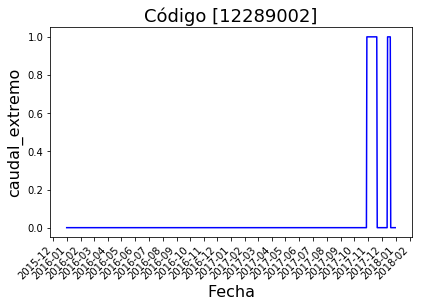

In [25]:
time_plot_una_estacion(12289002,'caudal_extremo', '2016/01/01', '2017/12/31')


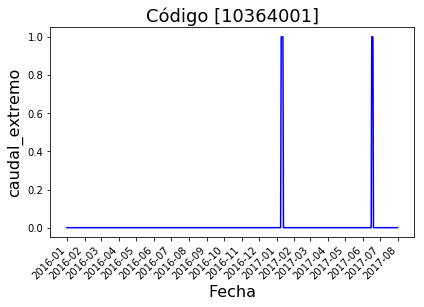

In [26]:
time_plot_una_estacion(10364001,'caudal_extremo', '2016/01/01', '2017/12/31')


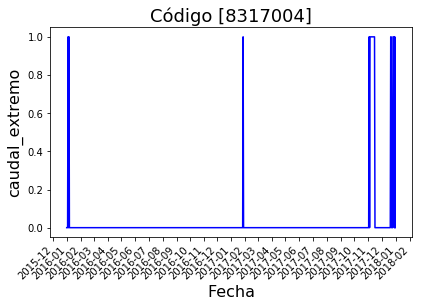

In [27]:
time_plot_una_estacion(8317004,'caudal_extremo', '2016/01/01', '2017/12/31')

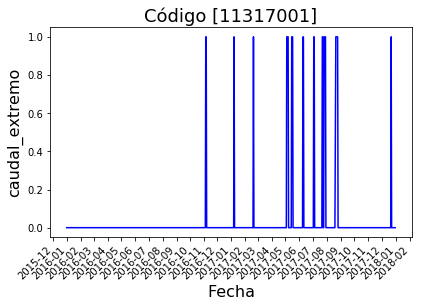

In [28]:
time_plot_una_estacion(11317001,'caudal_extremo', '2016/01/01', '2017/12/31')

Para analizar la variable caudal extremo, extraje datos de los años 2016-2017 para coomparar cuencas con mediciones es en el mismo periódo de tiempo. Luego utilizando la función creada más arriba hice comparación para 4 cuencas al azar y lo que se puede observar es que no existe un patrón común de comportamiento entre ellas.
Para poder tener una mejor noción de comparación creo habría que consideras más variables, como la ubicación geográfica por ejemplo.

# Eventos extremos a través del tiempo

In [29]:
#Creo Dataframe agrupando por año y calculo la proporción del total en cada uno para cada una se las 3 variables
datos_año = datos[['fecha','caudal_extremo','precip_extremo', 'temp_extremo']].groupby(datos.fecha.dt.year)
#datos_año.drop(columns = ['fecha'], inplace = True)
datos_año = datos_año.sum()
datos_año['caudal_extremo'] = datos_año['caudal_extremo']/datos['caudal_extremo'].sum()*100
datos_año['precip_extremo'] = datos_año['precip_extremo']/datos['precip_extremo'].sum()*100
datos_año['temp_extremo'] = datos_año['temp_extremo']/datos['temp_extremo'].sum()*100

datos_año


,caudal_extremo,precip_extremo,temp_extremo
fecha,,,
1960,0.001574,0.023325,0.021351
1961,0.000000,0.024139,0.018301
1962,0.023607,0.202331,0.215037
1963,0.250236,0.206399,0.247064
1964,0.113314,0.248981,0.166235
1965,1.493547,0.856787,0.454476
1966,1.118980,0.944392,0.373646
1967,0.468996,0.953071,0.457526
1968,0.083412,0.970971,1.011133


In [30]:
datos_año.reset_index(level=0, inplace=True)

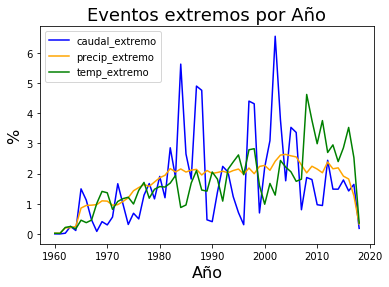

In [31]:
colores = ['blue', 'orange','green']
for indice, columna in enumerate(['caudal_extremo', 'precip_extremo', 'temp_extremo']):
    sns.lineplot(x = 'fecha', y = columna ,data = datos_año, color=colores[indice] , label = columna)
plt.title("Eventos extremos por Año", fontsize=18)
plt.xlabel('Año', fontsize=16)
plt.ylabel('%',fontsize=16)
plt.show()
    

De la visualización del gráfico, se puede concluir que en los últimos 60 años aprox. los eventos extremos de temperatura, presentas una tendencia al alza, se han ido haciendo más comunes. En cambio, si bien caudal tiene picks, más marcados en dos periódos de tiempo, no se concluye que actualmente ocurran con mayor frecuencia, y finalmente los eventos extremos de precipitación hasta 2005 aprox se ve una tendencia hacia arriba pero luego pierde un poco esa trayectoria.

# Modelos Predictivos

### Crear dataframe para predicción

In [48]:
# Nuevo dataframe con columnas elegidas
df = datos[['fecha', 'codigo_estacion', 'altura', 'latitud', 'longitud', 'caudal', 'precip_promedio', 'temp_max_promedio', 'season', 'precip_extremo', 'temp_extremo','caudal_extremo']]
# One-hot-encoding season
df = pd.get_dummies(df, prefix=['season'], columns=['season'])
#df['doy'] = df.fecha.dt.dayofyear
#df[['altura', 'latitud', 'longitud', 'doy']] = RobustScaler().fit_transform(df[['altura', 'latitud', 'longitud', 'doy']])
# Codigo_estacion to categorical
df['codigo_estacion'] = pd.Categorical(df['codigo_estacion']).codes

# Split dataframe en X e Y
df_X = df.drop(columns=['fecha', 'caudal_extremo'])
df_y = df['caudal_extremo']

### Split data en training y test

In [52]:
train_X, test_X, train_y, test_y = train_test_split(df_X, df_y, test_size=0.25, random_state=42)

## 1. XGBClassifier

In [57]:
xgb1 = XGBClassifier(
    learning_rate =0.007,
    n_estimators=1000,
    max_depth = 3,
    min_child_weight = 5,
    gamma=0.4,
    subsample=0.55,
    colsample_bytree=0.85,
    reg_alpha=0.005,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=19,
    seed=27
)
# modelfit(xgb1, train, train_X)
xgb1.fit(train_X, train_y)

NameError: name 'roc_auc_score' is not defined

### 1.1 XGBClassifier: Resultados

In [73]:
y_predict = xgb1.predict(train_X)
auc = roc_auc_score(train_y, y_predict)
print('Confusion matrix:\n', confusion_matrix(train_y, y_predict))
print('Train accuracy: %.4f %%' % accuracy_score(train_y, y_predict))
print('Train AUC: %.4f %%\n' % auc)

y_predict = xgb1.predict(test_X)
auc = roc_auc_score(test_y, y_predict)
print('Confusion matrix:\n', confusion_matrix(test_y, y_predict))
print('Test accuracy: %.4f %%' % accuracy_score(test_y, y_predict))
print('Test AUC: %.4f %%\n' % auc)

Confusion matrix:
 [[722425 172227]
 [  7724  39982]]
Train accuracy: 0.8090 %
Train AUC: 0.8228 %

Confusion matrix:
 [[240563  57723]
 [  2652  13182]]
Test accuracy: 0.8078 %
Test AUC: 0.8195 %



## 2. LogisticRegression

In [69]:
from sklearn.linear_model import LogisticRegression

model1 = LogisticRegression(random_state=42, solver='lbfgs', class_weight='balanced', max_iter=1000).fit(train_X, train_y)

### 2.1 LogisticRegression: Resultados

In [70]:
y_test_hat = model1.predict(test_X)
y_test_hat_probs = model1.predict_proba(test_X)[:,1]
test_accuracy = accuracy_score(test_y, y_test_hat)*100
test_auc_roc = roc_auc_score(test_y, y_test_hat_probs)*100
print('Confusion matrix:\n', confusion_matrix(test_y, y_test_hat))
print('Test accuracy: %.4f %%' % test_accuracy)
print('Test AUC: %.4f %%' % test_auc_roc)

Confusion matrix:
 [[210970  87316]
 [  6952   8882]]
Training accuracy: 69.9898 %
Training AUC: 70.2326 %


## Conclusión Modelos

De los modelos creados el que tiene mejor performance es el que utiliza XGBClassifier.
Como métrica de performance se utilizó "AUC - ROC curve" la cual es un método para medir distintos problemas de clasificación. Nos dice que tan bien el modelo es capaz de distinguir entre las distintas clases. Mientras más alto, mejor clasifica el modelo.
Cabe destacar que en ambos modelos creados se utilizó una medida para lidiar con el desbalance presente entre los ejemplos clasificados como "extremos". En el caso de XGBClassifier es el parámetro "scale_pos_weight" y en LogisticRegression es el parámetro "class_weight".